In [1]:
%load_ext autoreload
%autoreload 2

from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import spearmanr
import pickle

from settings import AMBIGUITY_PATH, AMBIGUITY_VARIATION, TWITTER_COUNTS, DEMOGRAPHICS_PATH
from src.analysis.variation import calculate_vocabulary_variation, embedded_CIs
from src.visualization.emoji_plotting import plot_emoji_barplot
from src.data.utils import parallelize_dataframe

sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.5)
sns.set_style("white", {'axes.grid' : False})

In [2]:
variations = pd.read_csv(AMBIGUITY_VARIATION)
variations.CIs = variations.CIs.apply(eval)

In [3]:
flags = [ '🏳️', "🏳️‍🌈", "🏴‍☠️" , "🏴󠁧󠁢󠁥󠁮󠁧󠁿" , "🏴󠁧󠁢󠁳󠁣󠁴󠁿", "🏴󠁧󠁢󠁷󠁬󠁳󠁿" ]
variations = variations[~variations.emoji.isin(flags)]

In [4]:
variations.vocabulary = variations.vocabulary.apply(lambda x: x[8:-1])
variations.vocabulary = variations.vocabulary.apply(eval)
variations['vocabulary size'] = variations.vocabulary.apply(len)

In [5]:
variations[variations.variation == variations.variation.max()]

,emoji,vocabulary,variation,mode_embedding,CIs,vocabulary size
1036,🛃,"{'mailman': 3, 'police': 3, 'conductor': 2, 'c...",0.745275,[ 9.6383e-02 8.1069e-01 1.6851e-01 2.0982e-...,"[0.6351632566590395, 0.8416571619055632]",21


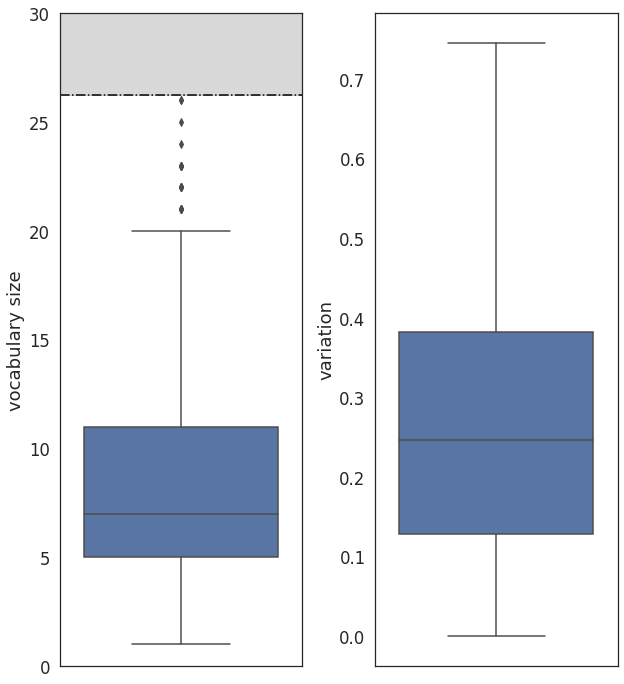

In [6]:
sns.set(rc={'figure.figsize':(10, 12)}, font_scale=1.5)
sns.set_style("white", {'axes.grid' : False})
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_ylim(bottom=0, top=30)
adjustment=0.25
ax1.axhline(y=variations["vocabulary size"].max()+adjustment, color='black', linestyle='-.')
sns.boxplot(data=variations, y='vocabulary size', ax=ax1)
ax1.fill_between(x=ax1.get_xlim(), y1=variations["vocabulary size"].max()+adjustment, y2=30, color='gray', alpha=0.3);

sns.boxplot(data=variations, y='variation', ax=ax2)
plt.subplots_adjust(wspace=0.3);


<AxesSubplot:xlabel='variation', ylabel='Probability'>

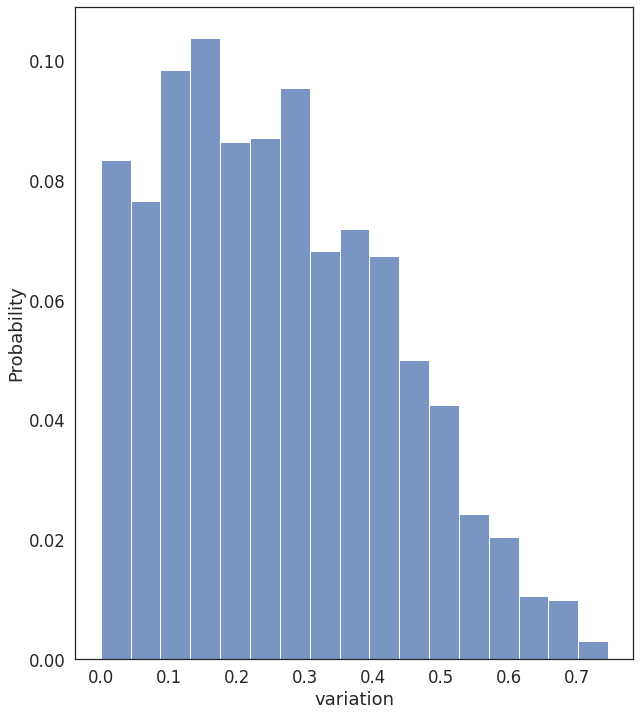

In [55]:
sns.histplot(data=variations.variation, stat='probability')

<AxesSubplot:ylabel='variation'>

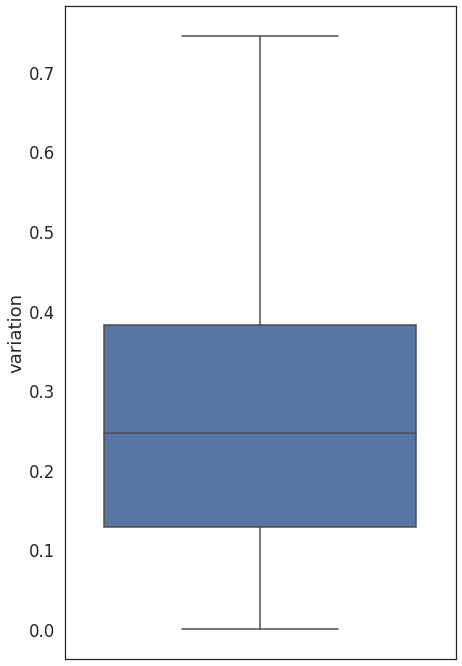

In [8]:
sns.set(rc={'figure.figsize':(7, 12)}, font_scale=1.5)
sns.set_style("white", {'axes.grid' : False})
sns.boxplot(data=variations, y='variation')

In [9]:
variations.describe()

,variation,vocabulary size
count,1319.000000,1319.000000
mean,0.261991,8.267627
std,0.164488,4.604093
min,0.000000,1.000000
25%,0.128395,5.000000
50%,0.247090,7.000000
75%,0.382758,11.000000
max,0.745275,26.000000


In [10]:
median_mask = variations.variation.sub(variations.variation.median()).abs().lt(0.001)
median_indices = median_mask[median_mask == True].index
print("Median emojis:")
print(variations.iloc[median_indices].emoji)

Median emojis:
26      ⏯️
307      🍬
520      👊
759      📬
953      😿
1133     🥅
1140     🥍
1244     🦾
Name: emoji, dtype: object


In [11]:
mean_mask = variations.variation.sub(variations.variation.mean()).abs().lt(0.001)
mean_indices = mean_mask[mean_mask == True].index
print("Mean emojis:")
print(variations.iloc[mean_indices].emoji)

Mean emojis:
35      ▪️
83      ♾️
314      🍳
816      🔦
904      😎
1090     🤙
Name: emoji, dtype: object


## Check variation vs mean duration

In [12]:
emojis = pd.read_csv(AMBIGUITY_PATH)

In [13]:
variations = variations.set_index("emoji")
variations["mean_duration"] = emojis.groupby("emoji").Duration.sum() / emojis.groupby("emoji").WorkerID.count()

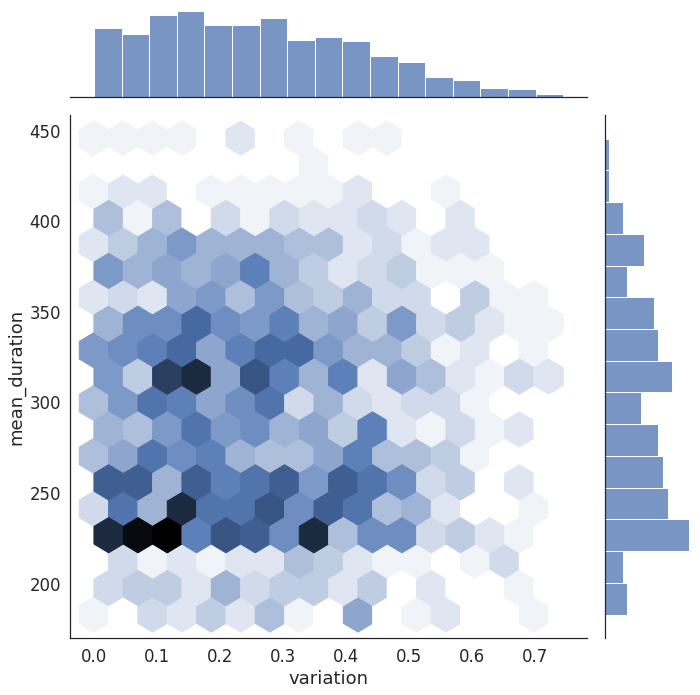

In [14]:
sns.jointplot(data=variations, x='variation', y='mean_duration', kind='hex', height=10);

In [15]:
variations.corr('spearman')

,variation,vocabulary size,mean_duration
variation,1.000000,0.846444,-0.011060
vocabulary size,0.846444,1.000000,-0.044009
mean_duration,-0.011060,-0.044009,1.000000


## Variation vs twitter frequency

In [16]:
twitter_count = pd.read_csv(TWITTER_COUNTS)
variations = pd.merge(variations, twitter_count, on='emoji', how='left').rename({"count": "twitter_count"}, axis=1)

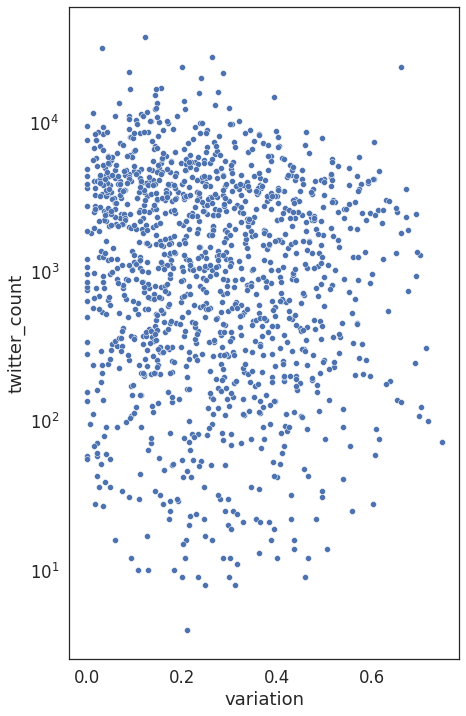

In [17]:
g = sns.scatterplot(data=variations, x='variation', y='twitter_count')
g.set_yscale("log")

In [18]:
spearmanr(variations.variation.values, variations.twitter_count.values, nan_policy='omit')

SpearmanrResult(correlation=-0.1254572146266235, pvalue=4.956166284022969e-06)

In [19]:
variations[variations.variation == 0.0].emoji.values

array(['🌈', '🍎', '🍿', '🐄', '🐝', '🐯', '👗', '👨\u200d👩\u200d👦',
       '👨\u200d👩\u200d👧', '👨\u200d👩\u200d👧\u200d👦',
       '👨\u200d👩\u200d👧\u200d👧', '👩\u200d👩\u200d👧\u200d👦', '💄', '🔑', '🔟',
       '🕷️', '🗝️', '🚿', '🥄', '🥕', '\U0001f965', '🦋'], dtype=object)

In [20]:
top_10_emojis = ["😂", "😭" ,"🥺" ,"❤️", "🤣", "✨", "😍", "🙏" ,"🥰" ,"😊"]

In [21]:
variations[variations.emoji.isin(top_10_emojis)][['emoji', 'variation',"CIs", 'vocabulary size']]

,emoji,variation,CIs,vocabulary size
137,✨,0.286655,"[0.19905387457331714, 0.38815446408658194]",10
149,❤️,0.122413,"[0.06120637059211731, 0.1836191117763519]",2
886,😂,0.263597,"[0.17523578896320288, 0.3661845717579126]",11
894,😊,0.275518,"[0.15078054678372363, 0.41454342215914614]",6
897,😍,0.199396,"[0.09142290392735351, 0.31112087756860995]",10
929,😭,0.168379,"[0.09910341016948224, 0.2574445306013028]",8
963,🙏,0.235942,"[0.13026698344740378, 0.3537072597842278]",9
1094,🤣,0.189952,"[0.12309257984161377, 0.26226780536983696]",11
1169,🥰,0.106312,"[0.04561617065359045, 0.17550797790840814]",8
1175,🥺,0.286097,"[0.18152902180498295, 0.38914176187844896]",15


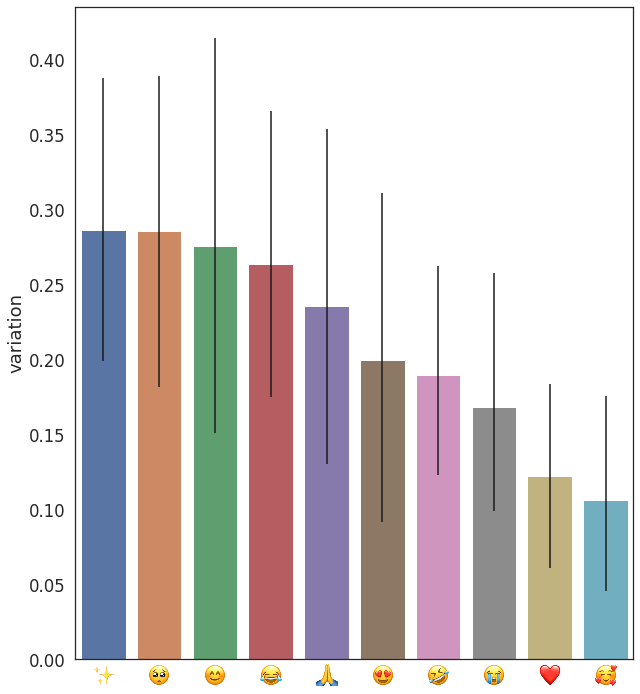

In [23]:
sns.set(rc={'figure.figsize':(10, 12)}, font_scale=1.5)
sns.set_style("white", {'axes.grid' : False})

top_ten = variations[variations.emoji.isin(top_10_emojis)][['emoji', 'variation', 'CIs', 'twitter_count']]
top_ten = top_ten.sort_values("variation", ascending=False).reset_index()

fig, ax = plt.subplots()
ax.tick_params(axis='x', colors='white')
plot_emoji_barplot(top_ten, ax, col='variation')

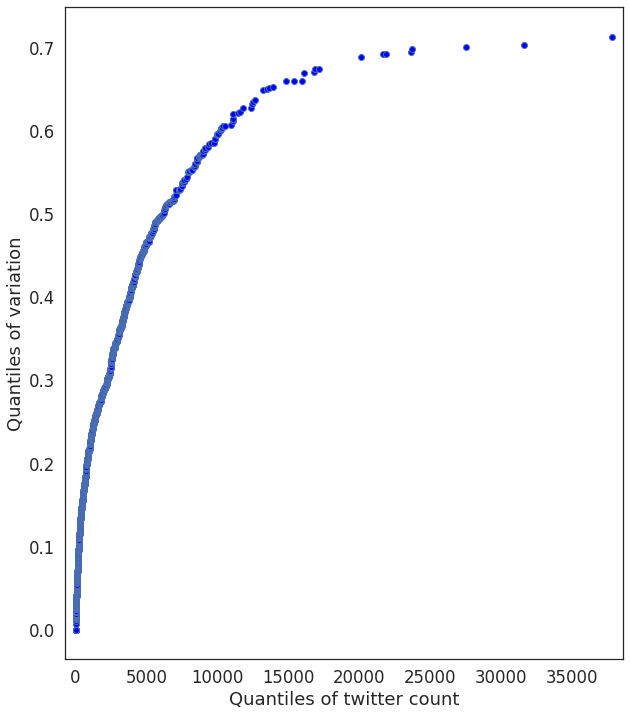

In [24]:
x = variations.variation.values
y = variations.twitter_count.values

pp_x = sm.ProbPlot(x)
pp_y = sm.ProbPlot(y)

# compare x quantiles to y quantiles
fig3 = pp_x.qqplot(other=pp_y, ylabel='Quantiles of variation',\
                                          xlabel='Quantiles of twitter count')

## Gender vs variation

In [82]:
from settings import FINAL_DF, EMBEDDINGS_PATH

from collections import Counter

from src.analysis.variation import calculate_vocabulary_variation, embedded_CIs
from src.analysis.variation import read_embeddings

In [83]:
demographics = pd.read_csv(DEMOGRAPHICS_PATH)
demographics.head()

,WorkerID,Age,Gender,Mothertongue
0,A10EQASJQODBUH,57.0,Female,english
1,A10T0161B70BXP,24.0,Male,english
2,A10VA2IF9D0HRI,39.0,Female,english
3,A11JBM10TZJGK7,24.0,Female,english
4,A11LSO6D7BMY99,59.0,Female,english


In [84]:
df = pd.read_csv(FINAL_DF, encoding='utf-8')
df.head()

,WorkerID,FormId,Duration,emoji_index,emoji,word,category,twitter_count
0,A19AAMLW7OP5V4,65,330.0,0,#️⃣,ash,symbols & signs,0.0
1,A1DD23J1WBGQUU,65,315.0,0,#️⃣,hashtag,symbols & signs,0.0
2,A2C7A6E70NYNUI,65,317.0,0,#️⃣,hashtag,symbols & signs,0.0
3,A2CK0OXMPOR9LE,65,521.0,0,#️⃣,pound,symbols & signs,0.0
4,A272X64FOZFYLB,65,329.0,0,#️⃣,pound,symbols & signs,0.0


In [85]:
df1 = pd.merge(df, demographics[['WorkerID', 'Age', 'Gender']], on='WorkerID')
females, males = df1[df1.Gender == 'Female'], df1[df1.Gender == 'Male']

In [95]:
def get_variation(df):
    print("Reading data...")
    word_embeddings = read_embeddings(EMBEDDINGS_PATH)

    print("Preprocessing...")
    vocabs = df[["emoji", "word"]] \
        .groupby("emoji").word \
        .apply(list).apply(Counter) \
        .reset_index() \
        .rename({"word": "vocabulary"}, axis=1)

    print("Calculating semantic variation in embedding space per emoji...")
    vocabs[["variation", "mode_embedding"]] = vocabs.apply(lambda row:
                                                                       calculate_vocabulary_variation(row.vocabulary,
                                                                                                      word_embeddings),
                                                                       axis=1,
                                                                       result_type='expand')
    return vocabs

In [96]:
female_vocabs, male_vocabs = get_variation(females), get_variation(males)
female_vocabs['annotators'] = 'females'
male_vocabs['annotators'] = 'males'

female_vocabs = female_vocabs.set_index("emoji")
male_vocabs = male_vocabs.set_index("emoji")

female_vocabs["mean_duration"] = females.groupby("emoji").Duration.sum() / females.groupby("emoji").WorkerID.count()
male_vocabs["mean_duration"] = males.groupby("emoji").Duration.sum() / males.groupby("emoji").WorkerID.count()

female_vocabs['vocabulary size'] = female_vocabs.vocabulary.apply(len)
male_vocabs['vocabulary size'] = male_vocabs.vocabulary.apply(len)

df = pd.concat((female_vocabs, male_vocabs))
df.head()

Reading data...
Preprocessing...
Calculating semantic variation in embedding space per emoji...
Reading data...
Preprocessing...
Calculating semantic variation in embedding space per emoji...


,vocabulary,variation,mode_embedding,annotators,mean_duration,vocabulary size
emoji,,,,,,
#️⃣,"{'ash': 2, 'hashtag': 3, 'number': 3, 'pound': 4}",0.497959,"[-0.90013, -0.0043639, 0.47695, 0.014165, -0.8...",females,402.166667,4
*️⃣,"{'star': 4, 'asterisk': 6, 'number': 1, 'pound...",0.570165,"[0.046689, -0.23131, 0.64926, -0.29223, -0.172...",females,276.800000,6
©️,"{'copywrite': 1, 'copyright': 10, 'c': 1, 'cor...",0.279054,"[-0.10602, -0.010289, -0.25982, 0.52433, 0.223...",females,241.937500,7
®️,"{'r': 5, 'rest': 1, 'restricted': 1, 'right': ...",0.544867,"[0.36664, -0.40631, 0.2368, 0.029964, 0.27124,...",females,271.176471,11
‼️,"{'important': 1, 'urgent': 1, 'punctuation': 1...",0.464738,"[0.80197, -1.3284, 0.83488, -0.13458, 0.1024, ...",females,222.294118,11


<AxesSubplot:xlabel='variation', ylabel='Count'>

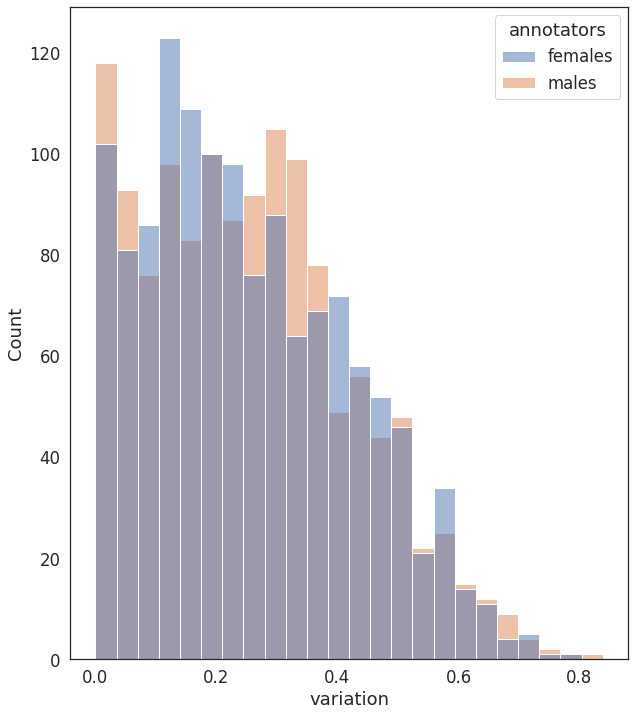

In [97]:
sns.histplot(data=df, x='variation', hue='annotators')

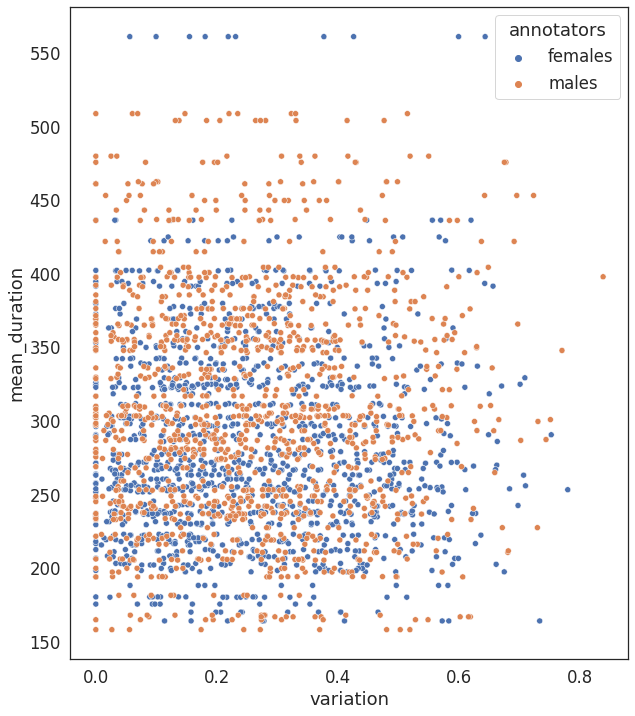

In [98]:
sns.scatterplot(data=df, x='variation', y='mean_duration', hue='annotators');

<AxesSubplot:xlabel='annotators', ylabel='vocabulary size'>

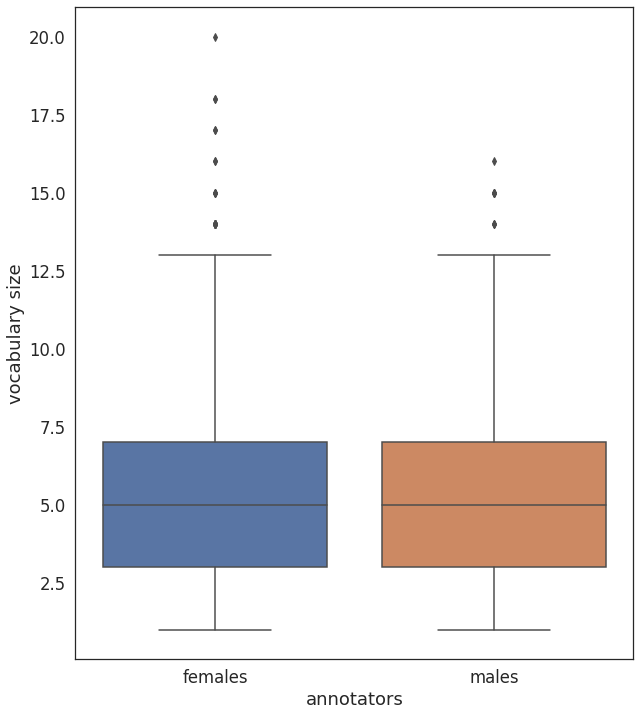

In [100]:
sns.boxplot(data=df, y='vocabulary size', x='annotators')